<h3>10.2 特征提取</h3>

In [14]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from datetime import datetime

In [15]:
trans_train = transforms.Compose(
    [transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trans_valid = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=trans_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=trans_valid)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


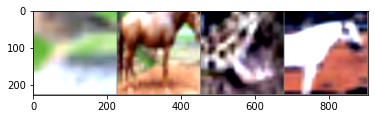

 bird horse  frog horse


In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 显示图像
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 随机获取部分训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images[:4]))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
# 使用预训练的模型
net = models.resnet18(pretrained=True)

In [18]:
# Freeze model weights
for param in net.parameters():
    param.requires_grad = False

In [19]:
# 将最后的全连接层改成十分类
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.fc = nn.Linear(512, 10)
# net = torch.nn.DataParallel(net)

In [20]:
# 查看总参数及训练参数
total_params = sum(p.numel() for p in net.parameters())
print('总参数个数:{}'.format(total_params))
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('需训练参数个数:{}'.format(total_trainable_params))

总参数个数:11181642
需训练参数个数:5130


In [21]:
net = net.to(device)

In [22]:
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total

In [23]:
criterion = nn.CrossEntropyLoss()
# 只需要优化最后一层参数
optimizer = torch.optim.SGD(net.fc.parameters(), lr=1e-3, weight_decay=1e-3,momentum=0.9)

In [24]:
def train(net, train_data, valid_data, num_epochs, optimizer, criterion):
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        for im, label in train_data:
            im = im.to(device)  # (bs, 3, h, w)
            label = label.to(device) # (bs, h, w)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                im = im.to(device)  # (bs, 3, h, w)
                label = label.to(device) # (bs, h, w)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

In [26]:
train(net, trainloader, testloader, 20, optimizer, criterion)

Epoch 0. Train Loss: 1.744918, Train Acc: 0.419280, Valid Loss: 1.172988, Valid Acc: 0.642800, Time 00:04:46
Epoch 1. Train Loss: 1.688845, Train Acc: 0.448320, Valid Loss: 0.861582, Valid Acc: 0.710800, Time 00:06:07
Epoch 2. Train Loss: 1.678831, Train Acc: 0.450420, Valid Loss: 0.969958, Valid Acc: 0.684000, Time 00:06:05
Epoch 3. Train Loss: 1.680549, Train Acc: 0.451280, Valid Loss: 0.853987, Valid Acc: 0.703500, Time 00:06:03
Epoch 4. Train Loss: 1.685168, Train Acc: 0.450920, Valid Loss: 0.884396, Valid Acc: 0.701100, Time 00:06:05
Epoch 5. Train Loss: 1.693243, Train Acc: 0.447660, Valid Loss: 0.928735, Valid Acc: 0.697500, Time 00:06:07
Epoch 6. Train Loss: 1.670359, Train Acc: 0.453280, Valid Loss: 0.846306, Valid Acc: 0.712500, Time 00:06:02
Epoch 7. Train Loss: 1.680441, Train Acc: 0.450680, Valid Loss: 0.893616, Valid Acc: 0.699700, Time 00:06:06


KeyboardInterrupt: 

<h3>10.3 数据增强</h3>